In [5]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model

In [6]:
def rank(a, p):
    return np.argsort(np.hstack((a, p)))[:,0]

a = np.random.uniform(0, 20, (10000, 1))
p = np.random.uniform(0, 20, (10000, 5))
r = np.reshape(rank(a, p), (10000, 1))
x1 = np.hstack((a, p, r))
y1 = np.random.uniform(0, 1, (10000, 1)) * (1 - r / 11)

In [7]:
regr = linear_model.LinearRegression()
regr.fit(x1, y1)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

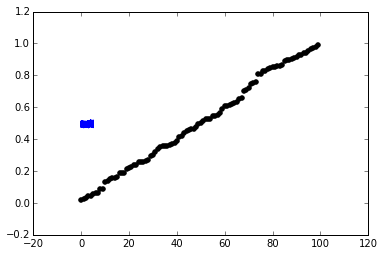

In [8]:
plt.scatter(np.arange(0, 100), np.sort(y1[0:100,], axis=0), color='black')
plt.plot(r, regr.predict(x1), color='blue', linewidth=1)

plt.show()